In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

2025-03-01 01:23:41.738324: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 01:23:41.843143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-01 01:23:41.843191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-01 01:23:41.856509: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 01:23:41.888232: I tensorflow/core/platform/cpu_feature_guar

## Load in z=0 quijote LR snapshot 663

In [24]:
idx_LH_str = '0663'
sim_name_quijote = f'quijote_LH{idx_LH_str}'

#dir_data = '/cosmos_storage/home/mpelle/Yin_data/Quijote'
dir_mocks = '/scratch/kstoreyf/Yin_data/Quijote' #hyp
fn_params = f'{dir_mocks}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']
param_dict = dict(zip(param_names, param_vals))
param_dict['tau'] = 0.0952 # ?? TODO check proper tau to be using!! 
cosmo_quijote = utils.get_cosmo(param_dict)

In [3]:
import readgadget

idx_LH = '663'
#snapshot = '/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/663/snapdir_004/snap_004' # 004 = z0 #atlas248
snapshot = f'/scratch/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/{idx_LH}/snapdir_004/snap_004' # 004 = z0 #hyperion
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

In [ ]:
# read positions, velocities and IDs of the particles
pos_snap = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
vel_snap = readgadget.read_block(snapshot, "VEL ", ptype)
print(pos_snap.shape, vel_snap.shape)
ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

(134217728, 3) (134217728, 3)


In [18]:
# ics
snapshot_ics = '/scratch/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/663/ICs/ics'
ids_ics = readgadget.read_block(snapshot_ics, "ID  ", ptype)-1   #IDs starting from 0

In [19]:

fn_lag_index = f'/scratch/kstoreyf/Quijote_simulations/quijote_LH{idx_LH}_neighfile.pickle'
with open(fn_lag_index, 'rb') as f:
    lag_index = pickle.load(f)
print(lag_index.shape)

(134217728,)


In [20]:
pos_snap_ord = pos_snap[lag_index]
vel_snap_ord = vel_snap[lag_index]

## Check velocity smoothing

In [7]:
def fv2bro(t_fv_field) :
    '''Returns back row ordered array (shape n_grid * n_grid * n_grid, 3) from front vector (shape 3, n_grid, n_grid, n_grid)'''
    return np.reshape(t_fv_field, (3, int(t_fv_field.size / 3))).T

In [8]:
def bro2fv(t_bro_field):
    '''Returns front vector ordered array (shape 3, n_grid, n_grid, n_grid) from back row (shape n_grid * n_grid * n_grid, 3)'''
    n_grid = int(np.cbrt(t_bro_field.shape[0]))
    t_bro_field_copy = t_bro_field.copy()
    t_bro_field_copy = t_bro_field_copy.reshape(n_grid, n_grid, n_grid, 3, order='C')
    t_bro_field_copy = t_bro_field_copy.transpose(3,0,1,2)
    return t_bro_field_copy

In [9]:
subdir_prefix='LH'

fn_disp = f'{dir_mocks}/{subdir_prefix}{idx_LH_str}/dis_{idx_LH_str}.npy'
fn_vel_sim = f'{dir_mocks}/{subdir_prefix}{idx_LH_str}/nlvel_{idx_LH_str}.npy'
#fn_vel_pred = f'{dir_mocks}/{subdir_prefix}{idx_LH_str}/pred_vel_{idx_LH_str}.npy'

disp = np.load(fn_disp)
vel_sim = np.load(fn_vel_sim)
velocities = fv2bro(vel_sim.copy(order='C'))
print(vel_sim.shape, velocities.shape)


(3, 512, 512, 512) (134217728, 3)


In [10]:
n_grid = 512
box_size = 1000.
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

#print("Adding predicted displacements")
pos = bacco.scaler.add_displacement(None,
                                    disp,
                                    box=box_size,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=False)[0]
print(disp.shape, pos.shape)

(3, 512, 512, 512) (134217728, 3)


In [11]:
n_grid = 512
# vel_snap_ord_copy = vel_snap_ord.copy()
# vel_snap_grid = vel_snap_ord_copy.reshape(n_grid, n_grid, n_grid, 3, order='C')
# vel_snap_grid = vel_snap_grid.transpose(3,0,1,2)
vel_snap_grid = bro2fv(vel_snap_ord)
vel_snap_mag = np.linalg.norm(vel_snap_grid, axis=0)
print(vel_snap_mag.shape)

(512, 512, 512)


1.3035313 6135.3345
1.3035313 6135.3345
(512, 512, 512)
(512, 512)


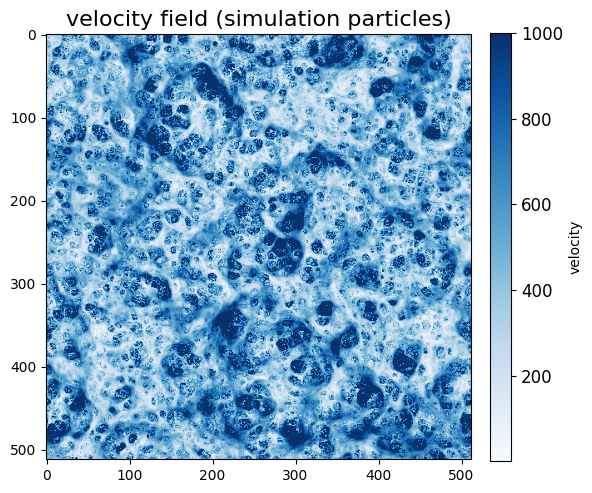

In [12]:
plotter.plot_field(vel_snap_mag, title=r'velocity field (simulation particles)',
                label_cbar='velocity', overdensity=False
                )

In [13]:
vel_sim_mag = np.linalg.norm(vel_sim, axis=0)

1.3035313 4356.5854
1.3035313 4356.5854
(512, 512, 512)
(512, 512)


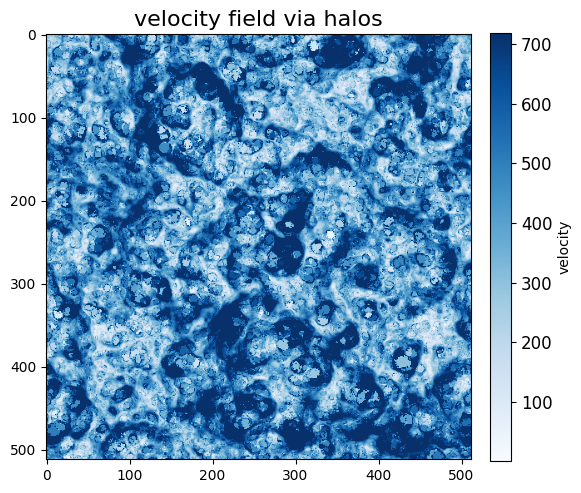

In [14]:
plotter.plot_field(vel_sim_mag, title=r'velocity field via halos',
                label_cbar='velocity', overdensity=False
                )

-5374.25 1758.3484
-5374.25 1758.3484
(512, 512, 512)
(512, 512)


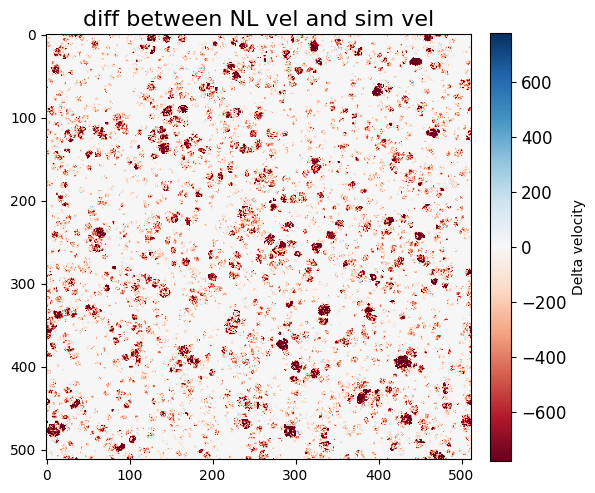

In [15]:
plotter.plot_field(vel_sim_mag-vel_snap_mag, title=r'diff between NL vel and sim vel',
                label_cbar='Delta velocity', overdensity=True
                )

In [16]:
from scipy.ndimage import gaussian_filter
# Calculate sigma in grid units

def smooth_velocities(vel_arr, smoothing_scale):
    sigma = smoothing_scale / (box_size / n_grid)
    vel_arr_smoothed = np.zeros_like(vel_arr)

    # Apply Gaussian filter to each velocity component
    for i in range(3):
        vel_arr_smoothed[i] = gaussian_filter(
            vel_arr[i], sigma=sigma, mode='wrap'
        )
    return vel_arr_smoothed 

In [17]:
vel_snap_grid_smoothedtiny = smooth_velocities(vel_snap_grid, smoothing_scale=0.001)

1.3035313 6135.3345
1.3035313 6135.3345
(512, 512, 512)
(512, 512)


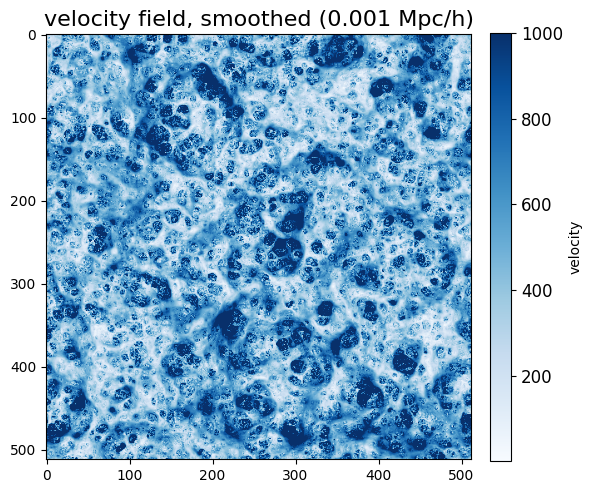

In [18]:
vel_snap_mag_smoothedtiny = np.linalg.norm(vel_snap_grid_smoothedtiny, axis=0)
vel_snap_ord_smoothedtiny = fv2bro(vel_snap_grid_smoothedtiny)
plotter.plot_field(vel_snap_mag_smoothedtiny, title=r'velocity field, smoothed (0.001 Mpc/h)',
                label_cbar='velocity', overdensity=False
                )

In [19]:
vel_snap_grid_smoothed2 = smooth_velocities(vel_snap_grid, smoothing_scale=2)

0.4404115 4459.441
0.4404115 4459.441
(512, 512, 512)
(512, 512)


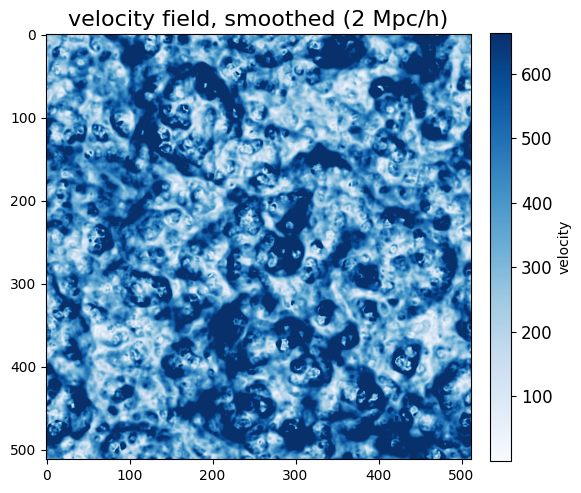

In [20]:
vel_snap_mag_smoothed2 = np.linalg.norm(vel_snap_grid_smoothed2, axis=0)
vel_snap_ord_smoothed2 = fv2bro(vel_snap_grid_smoothed2)
plotter.plot_field(vel_snap_mag_smoothed2, title=r'velocity field, smoothed (2 Mpc/h)',
                label_cbar='velocity', overdensity=False
                )

In [21]:
vel_snap_grid_smoothed4 = smooth_velocities(vel_snap_grid, smoothing_scale=4)

0.80746645 3164.387
0.80746645 3164.387
(512, 512, 512)
(512, 512)


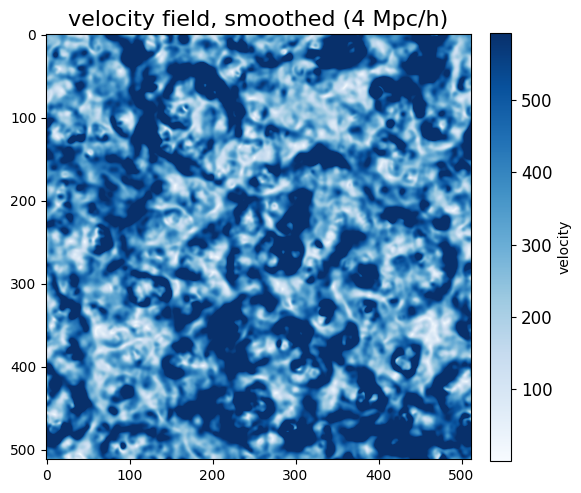

In [22]:
vel_snap_mag_smoothed4 = np.linalg.norm(vel_snap_grid_smoothed4, axis=0)
vel_snap_ord_smoothed4 = fv2bro(vel_snap_grid_smoothed4)
plotter.plot_field(vel_snap_mag_smoothed4, title=r'velocity field, smoothed (4 Mpc/h)',
                label_cbar='velocity', overdensity=False
                )

In [23]:
vel_snap_grid_smoothed8 = smooth_velocities(vel_snap_grid, smoothing_scale=8)

1.2427919 1843.5522
1.2427919 1843.5522
(512, 512, 512)
(512, 512)


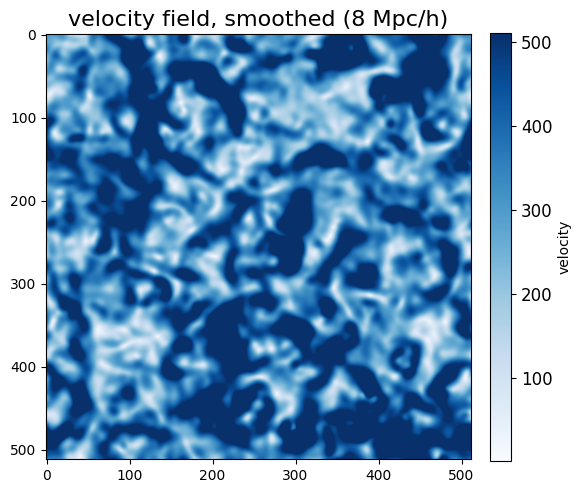

In [24]:
vel_snap_mag_smoothed8 = np.linalg.norm(vel_snap_grid_smoothed8, axis=0)
vel_snap_ord_smoothed8 = fv2bro(vel_snap_grid_smoothed8)
plotter.plot_field(vel_snap_mag_smoothed8, title=r'velocity field, smoothed (8 Mpc/h)',
                label_cbar='velocity', overdensity=False
                )

In [25]:
vel_snap_grid_smoothedbig = smooth_velocities(vel_snap_grid, smoothing_scale=32)

0.4712624 746.29034
0.4712624 746.29034
(512, 512, 512)
(512, 512)


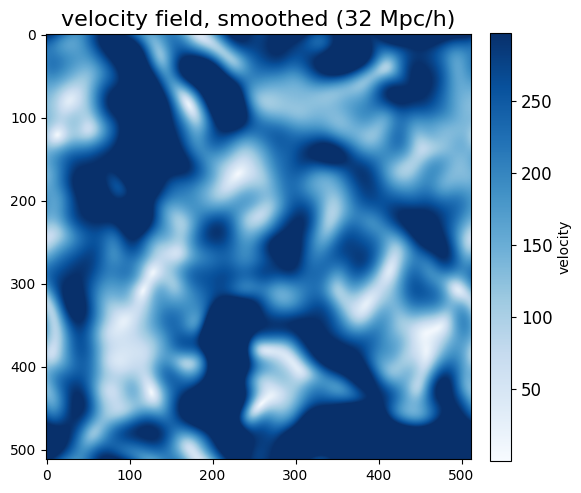

In [26]:
vel_snap_mag_smoothedbig = np.linalg.norm(vel_snap_grid_smoothedbig, axis=0)
vel_snap_ord_smoothedbig = fv2bro(vel_snap_grid_smoothedbig)
plotter.plot_field(vel_snap_mag_smoothedbig, title=r'velocity field, smoothed (32 Mpc/h)',
                label_cbar='velocity', overdensity=False
                )

In [27]:
k_min = 0.01
k_max = 1.0
n_bins = 30
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = True

# defaults from bacco.statistics.compute_power
# unless passed or otherwise denoted
args_power = {
    "ngrid": n_grid,
    "box": box_size,
    #"pos": None,
    #"vel": None,
    "mass": None,
    "interlacing": interlacing, #default: None
    "unit_in_Mpc": 1,
    "deposit_method": deposit_method, # default: 'cic',
    "bs_method": None,
    "bs_num_triangles": 10000,
    "bs_k1": 0.01,
    "bs_k2": None,
    "bs_deltak": None,
    "log_binning": log_binning,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid, #default: True,
    "deconvolve_grid": deconvolve_grid, #default: True,
    "normalise_grid": normalise_grid, #default: True,
    "totalmass": None,
    "correct_shotnoise": False,
    #"zspace": False,
    "cosmology": cosmo_quijote,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "grid1": None,
    "dilution": None,
    "folds": None,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "jack_error": False,
    "n_jack": None
}

# defaults from bacco.statistics.compute_crossspectrum_twogrids
# unless passed or otherwise denoted
args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    "ngrid": n_grid,
    "box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    #"zspace": False,
    "cosmology": cosmo_quijote,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

pknbody_dict = {
    'ngrid': n_grid,
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})


In [28]:
pk_obj_real = bacco.statistics.compute_powerspectrum(
    pos=pos_snap,
    vel=None,
    zspace=False,
    **args_power
)

2025-02-22 05:54:49,759 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2025-02-22 05:54:50,209 bacco.statistics :  setting the grid 512 False
2025-02-22 05:54:50,210 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-02-22 05:54:50,210 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb


2025-02-22 05:54:53,294 bacco.statistics :  mesh done in 3.08 s
2025-02-22 05:54:53,295 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.370149 sec
bacco.power : Counting modes


2025-02-22 05:54:54,239 bacco.statistics :  done compute.power
2025-02-22 05:54:54,240 bacco.statistics :  power done in 4.48 s


bacco.power : done counting modes in 0.434630 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays


In [29]:
pk_obj_zspace = bacco.statistics.compute_powerspectrum(
    pos=pos_snap,
    vel=vel_snap,
    zspace=True,
    **args_power
)

2025-02-22 05:54:55,597 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2025-02-22 05:54:55,599 bacco.statistics :  setting the grid 512 False
2025-02-22 05:54:55,599 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-02-22 05:54:55,599 bacco.statistics : starting deposit 1
2025-02-22 05:54:58,708 bacco.statistics :  mesh done in 3.11 s
2025-02-22 05:54:58,709 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.010000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.375772 sec
bacco.power : Counting modes


2025-02-22 05:54:59,659 bacco.statistics :  done compute.power
2025-02-22 05:54:59,660 bacco.statistics :  power done in 4.06 s


bacco.power : done counting modes in 0.430637 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000201 secs
bacco.power : Deallocating arrays


In [30]:
pk_obj_zspace_smoothed2 = bacco.statistics.compute_powerspectrum(
    pos=pos_snap_ord,
    vel=vel_snap_ord_smoothed2,
    zspace=True,
    **args_power
)

2025-02-22 05:55:01,046 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2025-02-22 05:55:01,048 bacco.statistics :  setting the grid 512 False
2025-02-22 05:55:01,049 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-02-22 05:55:01,049 bacco.statistics : starting deposit 1
2025-02-22 05:55:04,334 bacco.statistics :  mesh done in 3.28 s
2025-02-22 05:55:04,334 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.010000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.388725 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.432827 sec
bacco.power : Starting Fourier loop 


2025-02-22 05:55:05,431 bacco.statistics :  done compute.power
2025-02-22 05:55:05,432 bacco.statistics :  power done in 4.39 s


bacco.power : done Fourier loop in 0.000224 secs
bacco.power : Deallocating arrays


In [31]:
pk_obj_zspace_smoothed4 = bacco.statistics.compute_powerspectrum(
    pos=pos_snap_ord,
    vel=vel_snap_ord_smoothed4,
    zspace=True,
    **args_power
)

2025-02-22 05:55:06,786 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2025-02-22 05:55:06,788 bacco.statistics :  setting the grid 512 False
2025-02-22 05:55:06,789 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-02-22 05:55:06,789 bacco.statistics : starting deposit 1
2025-02-22 05:55:09,902 bacco.statistics :  mesh done in 3.11 s
2025-02-22 05:55:09,903 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.010000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.388638 sec
bacco.power : Counting modes


2025-02-22 05:55:11,002 bacco.statistics :  done compute.power
2025-02-22 05:55:11,003 bacco.statistics :  power done in 4.22 s


bacco.power : done counting modes in 0.438112 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000225 secs
bacco.power : Deallocating arrays


In [32]:
pk_obj_zspace_smoothed8 = bacco.statistics.compute_powerspectrum(
    pos=pos_snap_ord,
    vel=vel_snap_ord_smoothed8,
    zspace=True,
    **args_power
)

2025-02-22 05:55:12,317 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2025-02-22 05:55:12,319 bacco.statistics :  setting the grid 512 False
2025-02-22 05:55:12,319 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-02-22 05:55:12,319 bacco.statistics : starting deposit 1
2025-02-22 05:55:15,399 bacco.statistics :  mesh done in 3.08 s
2025-02-22 05:55:15,400 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.010000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1


2025-02-22 05:55:16,351 bacco.statistics :  done compute.power
2025-02-22 05:55:16,352 bacco.statistics :  power done in 4.03 s


bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.371087 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.433464 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000198 secs
bacco.power : Deallocating arrays


In [33]:
pk_obj_zspace_smoothedtiny = bacco.statistics.compute_powerspectrum(
    pos=pos_snap_ord,
    vel=vel_snap_ord_smoothedtiny,
    zspace=True,
    **args_power
)

2025-02-22 05:55:17,708 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2025-02-22 05:55:17,712 bacco.statistics :  setting the grid 512 False
2025-02-22 05:55:17,712 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-02-22 05:55:17,712 bacco.statistics : starting deposit 1
2025-02-22 05:55:20,790 bacco.statistics :  mesh done in 3.08 s
2025-02-22 05:55:20,790 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.010000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.370254 sec
bacco.power : Counting modes


2025-02-22 05:55:21,732 bacco.statistics :  done compute.power
2025-02-22 05:55:21,733 bacco.statistics :  power done in 4.02 s


bacco.power : done counting modes in 0.429139 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000199 secs
bacco.power : Deallocating arrays


In [34]:
pk_obj_zspace_smoothedbig = bacco.statistics.compute_powerspectrum(
    pos=pos_snap_ord,
    vel=vel_snap_ord_smoothedbig,
    zspace=True,
    **args_power
)

2025-02-22 05:55:23,202 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2025-02-22 05:55:23,205 bacco.statistics :  setting the grid 512 False
2025-02-22 05:55:23,206 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-02-22 05:55:23,206 bacco.statistics : starting deposit 1
2025-02-22 05:55:26,378 bacco.statistics :  mesh done in 3.17 s
2025-02-22 05:55:26,379 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.010000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.370667 sec
bacco.power : Counting modes


2025-02-22 05:55:27,322 bacco.statistics :  done compute.power
2025-02-22 05:55:27,323 bacco.statistics :  power done in 4.12 s


bacco.power : done counting modes in 0.429341 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000131 secs
bacco.power : Deallocating arrays


In [35]:
pk_obj_zspace_nlvel = bacco.statistics.compute_powerspectrum(
    pos=pos,
    vel=velocities,
    zspace=True,
    **args_power
)

2025-02-22 05:55:28,771 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2025-02-22 05:55:28,774 bacco.statistics :  setting the grid 512 False
2025-02-22 05:55:28,775 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-02-22 05:55:28,775 bacco.statistics : starting deposit 1
2025-02-22 05:55:31,938 bacco.statistics :  mesh done in 3.16 s
2025-02-22 05:55:31,939 bacco.statistics :  Starting the power spectrum calculation


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.010000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.374265 sec
bacco.power : Counting modes


2025-02-22 05:55:32,891 bacco.statistics :  done compute.power
2025-02-22 05:55:32,892 bacco.statistics :  power done in 4.12 s


bacco.power : done counting modes in 0.431657 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000227 secs
bacco.power : Deallocating arrays


/tmp/ipykernel_1743774/255108004.py:49: RuntimeWarning: invalid value encountered in divide
  ax1.plot(ks[i], (pks[i]-pk_obj_zspace['pk'])/pk_obj_zspace['pk'], ls=lss[i], label=labels[i],


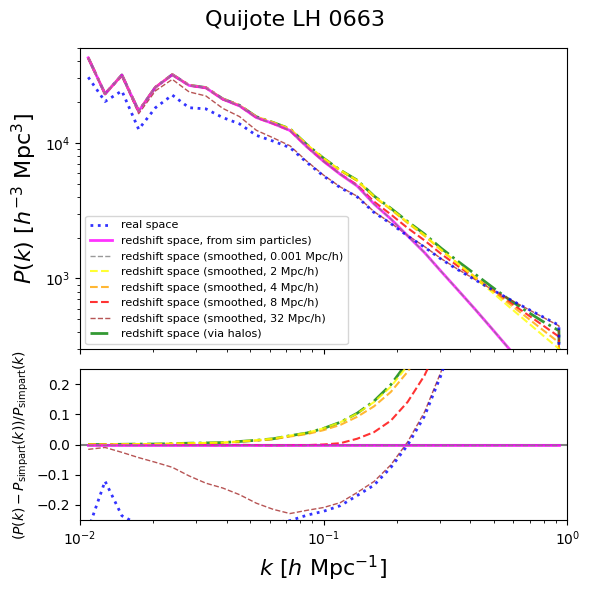

In [36]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr
alpha = 0.8

labels = [r'real space',
          r'redshift space, from sim particles)',
          r'redshift space (smoothed, 0.001 Mpc/h)',
          r'redshift space (smoothed, 2 Mpc/h)',
          r'redshift space (smoothed, 4 Mpc/h)',
          r'redshift space (smoothed, 8 Mpc/h)',
          r'redshift space (smoothed, 32 Mpc/h)',
          r'redshift space (via halos)',
          ]
colors = ['blue', 'magenta', 'grey', 'yellow', 'orange', 'red', 'brown', 'green']
lss = [':', '-', '--', '--', '--', '--', '--', '-.']
lws = [2, 2, 1, 1.5, 1.5, 1.5, 1, 2]
pk_objs = [pk_obj_real,
           pk_obj_zspace,
           pk_obj_zspace_smoothedtiny,
           pk_obj_zspace_smoothed2,
           pk_obj_zspace_smoothed4,
           pk_obj_zspace_smoothed8,
           pk_obj_zspace_smoothedbig,
           pk_obj_zspace_nlvel,
           ]
zorders = list(range(len(pk_objs),0,-1))
zorders[2] = 100
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(k_quijote)
# pks.append(pk_quijote)
# errs.append(err_quijote)
#errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$, Quijote measured')
# colors.append('grey')
# lss.append('-')
# zorders.append(0)
plt.suptitle(f'Quijote LH {idx_LH_str}', fontsize=16)

#ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=3)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], lw=lws[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    
    ax1.plot(ks[i], (pks[i]-pk_obj_zspace['pk'])/pk_obj_zspace['pk'], ls=lss[i], label=labels[i], 
              lw=lws[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    # if len(pk_emu)!=len(pks[i]):
    #     pk_interp = np.interp(kk, ks[i], pks[i])
    #     err_interp = np.interp(kk, ks[i], errs[i])
    #     ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    #     ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    # else:
    #     ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    #     ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


ax1.axhline(0.0, color='grey')

axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P(k)-P_\text{simpart}(k))/P_\text{simpart}(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)
ax1.set_xscale('log')

ax1.set_ylim(-0.25, 0.25)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

## Redshift dependence of resolution issues

In [4]:
import readgadget

idx_LH = '663'
n_grid = 512
box_size = 1000.

In [11]:

snapnums = ['000', '001', '002', '003', '004']
snapnum2redshift = {}
snapnum2expfactor = {}
for snapnum in snapnums:
    snapshot = f'/scratch/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/{idx_LH}/snapdir_{snapnum}/snap_{snapnum}' # 004 = z0 #hyperionptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

    header = readgadget.header(snapshot)
    redshift = header.redshift
    expfactor = 1.0/(1.0+redshift)
    snapnum2redshift[snapnum] = redshift
    snapnum2expfactor[snapnum] = expfactor

print(snapnum2redshift)

{'000': 3.0000000309860937, '001': 2.0000000106593414, '002': 1.0000000077465243, '003': 0.5000000130761943, '004': 2.220446049250313e-16}


In [5]:

def create_bias_fields_lag(snapnum='004', n_grid=512, box_size=1000.):

    expfactor = snapnum2expfactor[snapnum]
    cosmo_quijote_z = utils.get_cosmo(param_dict, a_scale=expfactor)

    ngenic_phases = True
    phase_type = 1

    seed = int(idx_LH)
    FixedInitialAmplitude = False

    sim_2lpt, disp_2lpt = bacco.utils.create_lpt_simulation(cosmo_quijote_z, box_size, Nmesh=n_grid, Seed=seed,
                                                        FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                        expfactor=expfactor, LPT_order=2, order_by_order=None,
                                                        phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                        sphere_mode=0)
    dens_lin_2lpt = sim_2lpt.get_linear_field(ngrid=n_grid, quantity='delta', damping_scale=0.75)
    bmodel = bacco.BiasModel(sim=None, linear_delta=dens_lin_2lpt, ngrid=n_grid, ngrid1=None,
                            sdm=False, mode="dm", 
                            BoxSize=box_size,
                            npart_for_fake_sim=n_grid, 
                            bias_model='expansion', deposit_method="cic",
                            use_displacement_of_nn=False, interlacing=False,
                            )
    bias_fields_lag = bmodel.bias_terms_lag()
    
    return bias_fields_lag

In [17]:
def compute_bias_fields_eul(bias_fields_lag, snapnum='004', n_grid=512, box_size=1000.,
                            n_fac_dilute=None):
    
    if n_grid==512:
        tag_res = ''
    elif n_grid==1024:
        tag_res = '_HR'
    else:
        raise ValueError('ngrid must be either 512 or 1024')
    
    fn_lag_index = f'/scratch/kstoreyf/Quijote_simulations/quijote_LH{idx_LH}{tag_res}_snap{snapnum}_neighfile.pickle'
    with open(fn_lag_index, 'rb') as f:
        lag_index = pickle.load(f)
    
    snapshot = f'/scratch/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube{tag_res}/{idx_LH}/snapdir_{snapnum}/snap_{snapnum}' # 004 = z0 #hyperionptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

    # read positions, velocities and IDs of the particles
    pos_raw = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
    #ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

    fn_lag_index = f'/scratch/kstoreyf/Quijote_simulations/quijote_LH{idx_LH}{tag_res}_snap{snapnum}_neighfile.pickle'
    with open(fn_lag_index, 'rb') as f:
        lag_index = pickle.load(f)
    print(lag_index.shape)

    pos = pos_raw[lag_index]

    if n_fac_dilute is not None:
        pos_grid = pos.reshape(n_grid, n_grid, n_grid,3)
        # _lag_index_HR = lag_index_HR.reshape(n_grid_HR,n_grid_HR, n_grid_HR)
        # _lag_index_HR = lag_index_HR[::ndilution,::ndilution,::ndilution]
        spos = pos_grid[::n_fac_dilute,::n_fac_dilute,::n_fac_dilute,:]
        n_grid_dil = n_grid//n_fac_dilute
        pos = spos.reshape(n_grid_dil**3, 3)
        # update n_grid
        n_grid = n_grid_dil

    bias_terms_eul_LR =[]
    for ii in range(0,len(bias_fields_lag)):
        bias_terms = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos, 
                                mass = (bias_fields_lag[ii]).flatten(), deposit_method='cic', 
                                interlacing=False)
        bias_terms_eul_LR.append(bias_terms)
    bias_terms_eul_LR = np.array(bias_terms_eul_LR)
    
    return bias_terms_eul_LR

In [18]:
k_min = 0.01
k_max = 0.68
n_bins = 30
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = False

args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    #"box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    #"cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

In [19]:
def compute_pk_terms(bias_terms_eul, snapnum='004', n_grid=512, box_size=1000.):
        #Compute the P(k) of the 15 terms
    import itertools

    expfactor = snapnum2expfactor[snapnum]
    cosmo_quijote_z = utils.get_cosmo(param_dict, a_scale=expfactor)
    
    lt_k = np.logspace(np.log10(np.pi / box_size), np.log10(2 * np.pi / box_size * n_grid), num=30)
    pk_lpt = bacco.utils.compute_pt_15_basis_terms(cosmo_quijote_z, expfactor=cosmo_quijote_z.expfactor, wavemode=lt_k)

    prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul.shape[0]),r=2)))
    #is_pnn_subset = [0,1,5]
    is_pnn_subset = [0, 5]

    bias_terms_eul_norm = bias_terms_eul/n_grid**3
    power_all_terms = []
    for ii in range(0,len(prod)):
        if ii not in is_pnn_subset:
            power_all_terms.append(None)
            continue
        
        pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
        if ii in [2,3,4,7,8,11,13]:
            pk_lt['pk_lt_log'] = False
        args_power_grid_ii = args_power_grid.copy()
        #args_power_grid_ii['correct_grid'] = False if ii == 11 else True
        args_power_grid_ii['correct_grid'] = True #TRYING
        print(prod[ii]) 
        power_term = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm[prod[ii,0]],
                                                        grid2=bias_terms_eul_norm[prod[ii,1]],
                                                        ngrid=n_grid,
                                                        cosmology=cosmo_quijote_z,
                                                        box=box_size,
                                                        **args_power_grid_ii)
        power_all_terms.append(power_term)
        
    return power_all_terms

#### run loops

In [63]:
# leaving off 000 because its at expfac 0.25 which is below emu limit
snapnums = ['001', '002', '003', '004']
#snapnums = ['001']

bias_fields_lag_arr = []
for snapnum in snapnums:
    bias_fields_lag = create_bias_fields_lag(snapnum=snapnum)
    bias_fields_lag_arr.append(bias_fields_lag)

2025-03-01 00:02:55,615 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2025-03-01 00:02:55,618 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2025-03-01 00:02:55,618 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2025-03-01 00:02:55,618 bacco.sims : ...done in 0.000953 s
INFO:bacco.sims:...done in 0.000953 s


bacco.lss_scaler : 293 P(k) values; Di = (0.415148, 0.171050, 0.071550, 0.071550); nthreads =64; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=7.7821e-18 
l2=6.73432e-17 
l2=-3.85992e-17 
l2=-3.25661e-18 
l2=-4.83533e-17 
l2=-1.04121e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.14211e-08 l3a=3.105e-08 l3b=4.34859e-08


2025-03-01 00:03:35,022 bacco.scaler : Adding displacement field with a vel-factor=97.992416
INFO:bacco.scaler:Adding displacement field with a vel-factor=97.992416


bacco.lss_scaler:  Adding LSS displacement: vel_factor=97.992416 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.lss_scaler : 293 P(k) values; Di = (0.415148, 0.171050, 0.071550, 0.071550); nthreads =64; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2025-03-01 00:03:41,203 bacco.BiasModel : Initialising Bias Model class ...
INFO:bacco.BiasModel:Initialising Bias Model class ...
2025-03-01 00:03:46,324 bacco.BiasModel : Computing delta_to_tidal_field with 64 threads...
INFO:bacco.BiasModel:Computing delta_to_tidal_field with 64 threads...
2025-03-01 00:03:46,325 bacco.BiasModel : fttw plan
INFO:bacco.BiasModel:fttw plan
2025-03-01 00:03:46,326 bacco.BiasModel : Computing linear field ...
INFO:bacco.BiasModel:Computing linear field ...
2025-03-01 00:03:46,327 bacco.BiasModel : Memory used: 18.461011968 Gigabytes
INFO:bacco.BiasModel:Memory used: 18.461011968 Gigabytes
2025-03-01 00:03:46,337 bacco.BiasModel : fttw freqs
INFO:bacco.BiasModel:fttw freqs
2025-03-01 00:03:46,338 bacco.BiasModel : tidk freqs
INFO:bacco.BiasModel:tidk freqs
2025-03-01 00:04:57,129 bacco.BiasModel : ifft
INFO:bacco.BiasModel:ifft
2025-03-01 00:06:54,402 bacco.BiasModel : Computing laplacian ...
INFO:bacco.BiasModel:Computing laplacian ...
2025-03-01 00:06:

bacco.lss_scaler : 293 P(k) values; Di = (0.604295, 0.362829, 0.220672, 0.220672); nthreads =64; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=7.7821e-18 
l2=6.73432e-17 
l2=-3.85992e-17 
l2=-3.25661e-18 
l2=-4.83533e-17 
l2=-1.04121e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.14211e-08 l3a=3.105e-08 l3b=4.34859e-08


2025-03-01 00:09:38,408 bacco.scaler : Adding displacement field with a vel-factor=79.407918
INFO:bacco.scaler:Adding displacement field with a vel-factor=79.407918


bacco.lss_scaler:  Adding LSS displacement: vel_factor=79.407918 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.lss_scaler : 293 P(k) values; Di = (0.604295, 0.362829, 0.220672, 0.220672); nthreads =64; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2025-03-01 00:09:43,331 bacco.BiasModel : Initialising Bias Model class ...
INFO:bacco.BiasModel:Initialising Bias Model class ...
2025-03-01 00:09:47,693 bacco.BiasModel : Computing delta_to_tidal_field with 64 threads...
INFO:bacco.BiasModel:Computing delta_to_tidal_field with 64 threads...
2025-03-01 00:09:47,694 bacco.BiasModel : fttw plan
INFO:bacco.BiasModel:fttw plan
2025-03-01 00:09:47,695 bacco.BiasModel : Computing linear field ...
INFO:bacco.BiasModel:Computing linear field ...
2025-03-01 00:09:47,696 bacco.BiasModel : Memory used: 18.397380608 Gigabytes
INFO:bacco.BiasModel:Memory used: 18.397380608 Gigabytes
2025-03-01 00:09:47,703 bacco.BiasModel : fttw freqs
INFO:bacco.BiasModel:fttw freqs
2025-03-01 00:09:47,704 bacco.BiasModel : tidk freqs
INFO:bacco.BiasModel:tidk freqs
2025-03-01 00:11:00,962 bacco.BiasModel : ifft
INFO:bacco.BiasModel:ifft
2025-03-01 00:13:09,117 bacco.BiasModel : Computing laplacian ...
INFO:bacco.BiasModel:Computing laplacian ...
2025-03-01 00:13:

bacco.lss_scaler : 293 P(k) values; Di = (0.766674, 0.585064, 0.450642, 0.450642); nthreads =64; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=7.7821e-18 
l2=6.73432e-17 
l2=-3.85992e-17 
l2=-3.25661e-18 
l2=-4.83533e-17 
l2=-1.04121e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.14211e-08 l3a=3.105e-08 l3b=4.34859e-08


2025-03-01 00:15:54,663 bacco.scaler : Adding displacement field with a vel-factor=67.897438
INFO:bacco.scaler:Adding displacement field with a vel-factor=67.897438


bacco.lss_scaler:  Adding LSS displacement: vel_factor=67.897438 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.lss_scaler : 293 P(k) values; Di = (0.766674, 0.585064, 0.450642, 0.450642); nthreads =64; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2025-03-01 00:15:59,158 bacco.BiasModel : Initialising Bias Model class ...
INFO:bacco.BiasModel:Initialising Bias Model class ...
2025-03-01 00:16:02,905 bacco.BiasModel : Computing delta_to_tidal_field with 64 threads...
INFO:bacco.BiasModel:Computing delta_to_tidal_field with 64 threads...
2025-03-01 00:16:02,906 bacco.BiasModel : fttw plan
INFO:bacco.BiasModel:fttw plan
2025-03-01 00:16:02,906 bacco.BiasModel : Computing linear field ...
INFO:bacco.BiasModel:Computing linear field ...
2025-03-01 00:16:02,907 bacco.BiasModel : Memory used: 23.768346624 Gigabytes
INFO:bacco.BiasModel:Memory used: 23.768346624 Gigabytes
2025-03-01 00:16:02,915 bacco.BiasModel : fttw freqs
INFO:bacco.BiasModel:fttw freqs
2025-03-01 00:16:02,915 bacco.BiasModel : tidk freqs
INFO:bacco.BiasModel:tidk freqs
2025-03-01 00:17:05,954 bacco.BiasModel : ifft
INFO:bacco.BiasModel:ifft
2025-03-01 00:18:59,973 bacco.BiasModel : Computing laplacian ...
INFO:bacco.BiasModel:Computing laplacian ...
2025-03-01 00:18:

bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=7.7821e-18 
l2=6.73432e-17 
l2=-3.85992e-17 
l2=-3.25661e-18 
l2=-4.83533e-17 
l2=-1.04121e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.14211e-08 l3a=3.105e-08 l3b=4.34859e-08


2025-03-01 00:21:50,235 bacco.scaler : Adding displacement field with a vel-factor=53.391221
INFO:bacco.scaler:Adding displacement field with a vel-factor=53.391221


bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.391221 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2025-03-01 00:21:54,428 bacco.BiasModel : Initialising Bias Model class ...
INFO:bacco.BiasModel:Initialising Bias Model class ...
2025-03-01 00:21:59,296 bacco.BiasModel : Computing delta_to_tidal_field with 64 threads...
INFO:bacco.BiasModel:Computing delta_to_tidal_field with 64 threads...
2025-03-01 00:21:59,297 bacco.BiasModel : fttw plan
INFO:bacco.BiasModel:fttw plan
2025-03-01 00:21:59,298 bacco.BiasModel : Computing linear field ...
INFO:bacco.BiasModel:Computing linear field ...
2025-03-01 00:21:59,298 bacco.BiasModel : Memory used: 29.13241088 Gigabytes
INFO:bacco.BiasModel:Memory used: 29.13241088 Gigabytes
2025-03-01 00:21:59,306 bacco.BiasModel : fttw freqs
INFO:bacco.BiasModel:fttw freqs
2025-03-01 00:21:59,306 bacco.BiasModel : tidk freqs
INFO:bacco.BiasModel:tidk freqs
2025-03-01 00:23:05,975 bacco.BiasModel : ifft
INFO:bacco.BiasModel:ifft
2025-03-01 00:25:19,311 bacco.BiasModel : Computing laplacian ...
INFO:bacco.BiasModel:Computing laplacian ...
2025-03-01 00:25:19

In [64]:
for i, snapnum in enumerate(snapnums):
    fn_bias_fields_lag = f'/scratch/kstoreyf/muchisimocks/data/bias_fields_lag_{idx_LH}_snap{snapnum}.npy'
    np.save(fn_bias_fields_lag, bias_fields_lag_arr[i])

In [65]:
bias_fields_eul_arr = []
for i, snapnum in enumerate(snapnums):
    bias_fields_eul = compute_bias_fields_eul(bias_fields_lag_arr[i], snapnum=snapnum)
    bias_fields_eul_arr.append(bias_fields_eul)

(134217728,)


2025-03-01 00:28:55,568 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:28:57,182 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:28:57,716 bacco.statistics :  mesh done in 2.15 s
INFO:bacco.statistics: mesh done in 2.15 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:29:00,939 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:29:03,024 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:29:03,556 bacco.statistics :  mesh done in 2.62 s
INFO:bacco.statistics: mesh done in 2.62 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:29:07,125 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:29:08,449 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:29:08,988 bacco.statistics :  mesh done in 1.86 s
INFO:bacco.statistics: mesh done in 1.86 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:29:11,932 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:29:13,249 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:29:13,792 bacco.statistics :  mesh done in 1.86 s
INFO:bacco.statistics: mesh done in 1.86 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:29:17,917 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:29:19,364 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0


2025-03-01 00:29:19,901 bacco.statistics :  mesh done in 1.98 s
INFO:bacco.statistics: mesh done in 1.98 s


bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
(134217728,)


2025-03-01 00:29:39,886 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:29:41,230 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:29:41,767 bacco.statistics :  mesh done in 1.88 s
INFO:bacco.statistics: mesh done in 1.88 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:29:45,349 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:29:46,708 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:29:47,250 bacco.statistics :  mesh done in 1.9 s
INFO:bacco.statistics: mesh done in 1.9 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:29:50,373 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:29:51,650 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:29:52,182 bacco.statistics :  mesh done in 1.81 s
INFO:bacco.statistics: mesh done in 1.81 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:29:54,766 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:29:56,179 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:29:56,714 bacco.statistics :  mesh done in 1.95 s
INFO:bacco.statistics: mesh done in 1.95 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:29:59,796 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:30:01,101 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:30:01,626 bacco.statistics :  mesh done in 1.83 s
INFO:bacco.statistics: mesh done in 1.83 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
(134217728,)


2025-03-01 00:30:17,227 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:30:18,321 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:30:18,869 bacco.statistics :  mesh done in 1.64 s
INFO:bacco.statistics: mesh done in 1.64 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:30:21,803 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:30:23,073 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:30:23,601 bacco.statistics :  mesh done in 1.8 s
INFO:bacco.statistics: mesh done in 1.8 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:30:26,729 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:30:28,066 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:30:28,593 bacco.statistics :  mesh done in 1.86 s
INFO:bacco.statistics: mesh done in 1.86 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:30:31,482 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:30:32,839 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:30:33,370 bacco.statistics :  mesh done in 1.89 s
INFO:bacco.statistics: mesh done in 1.89 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:30:36,572 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:30:37,941 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:30:38,465 bacco.statistics :  mesh done in 1.89 s
INFO:bacco.statistics: mesh done in 1.89 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
(134217728,)


2025-03-01 00:30:52,543 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:30:53,730 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:30:54,267 bacco.statistics :  mesh done in 1.72 s
INFO:bacco.statistics: mesh done in 1.72 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:30:56,836 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:30:58,125 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:30:58,657 bacco.statistics :  mesh done in 1.82 s
INFO:bacco.statistics: mesh done in 1.82 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:31:02,380 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:31:03,594 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:31:04,126 bacco.statistics :  mesh done in 1.75 s
INFO:bacco.statistics: mesh done in 1.75 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:31:07,754 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:31:09,353 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2025-03-01 00:31:09,897 bacco.statistics :  mesh done in 2.14 s
INFO:bacco.statistics: mesh done in 2.14 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 00:31:13,123 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 00:31:14,462 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb


2025-03-01 00:31:14,997 bacco.statistics :  mesh done in 1.87 s
INFO:bacco.statistics: mesh done in 1.87 s


bacco.mesh : binning of 134217728 particles (134217728 with mass)


In [66]:
power_all_terms_arr = []
for i, snapnum in enumerate(snapnums):
    power_all_terms = compute_pk_terms(bias_fields_eul_arr[i], snapnum=snapnum)
    power_all_terms_arr.append(power_all_terms)

2025-03-01 00:34:07,905 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing the power spectrum with ngrid=512 and interlacing=False


[0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.948769 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.380268 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000132 secs
bacco.power : Deallocating arrays


2025-03-01 00:34:20,439 bacco.statistics :  ...done in 12.5 s
INFO:bacco.statistics: ...done in 12.5 s
2025-03-01 00:34:20,440 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing the power spectrum with ngrid=512 and interlacing=False


[1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.23504e-11 (grid1) 1.23504e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.874927 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.375477 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000130 secs
bacco.power : Deallocating arrays


2025-03-01 00:34:32,465 bacco.statistics :  ...done in 12.0 s
INFO:bacco.statistics: ...done in 12.0 s
2025-03-01 00:34:48,917 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing the power spectrum with ngrid=512 and interlacing=False


[0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.954827 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.382534 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000204 secs
bacco.power : Deallocating arrays


2025-03-01 00:35:05,542 bacco.statistics :  ...done in 16.6 s
INFO:bacco.statistics: ...done in 16.6 s
2025-03-01 00:35:05,544 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing the power spectrum with ngrid=512 and interlacing=False


[1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -3.48472e-11 (grid1) -3.48472e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.954830 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.379185 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000224 secs
bacco.power : Deallocating arrays


2025-03-01 00:35:21,720 bacco.statistics :  ...done in 16.2 s
INFO:bacco.statistics: ...done in 16.2 s
2025-03-01 00:35:35,195 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing the power spectrum with ngrid=512 and interlacing=False


[0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.765288 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.380163 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000223 secs
bacco.power : Deallocating arrays


2025-03-01 00:35:51,230 bacco.statistics :  ...done in 16.0 s
INFO:bacco.statistics: ...done in 16.0 s
2025-03-01 00:35:51,232 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing the power spectrum with ngrid=512 and interlacing=False


[1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.72858e-11 (grid1) -5.72858e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.943489 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.376202 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000227 secs
bacco.power : Deallocating arrays


2025-03-01 00:36:04,592 bacco.statistics :  ...done in 13.4 s
INFO:bacco.statistics: ...done in 13.4 s
2025-03-01 00:36:14,901 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing the power spectrum with ngrid=512 and interlacing=False


[0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.855166 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.378923 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000223 secs
bacco.power : Deallocating arrays


2025-03-01 00:36:27,748 bacco.statistics :  ...done in 12.8 s
INFO:bacco.statistics: ...done in 12.8 s
2025-03-01 00:36:27,749 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
INFO:bacco.statistics:Computing the power spectrum with ngrid=512 and interlacing=False


[1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.69501e-11 (grid1) 9.69501e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.842382 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.377404 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000128 secs
bacco.power : Deallocating arrays


2025-03-01 00:36:40,814 bacco.statistics :  ...done in 13.1 s
INFO:bacco.statistics: ...done in 13.1 s


#### emu and predictions

In [30]:
dir_emus_lbias = '/home/kstoreyf/external' #hyperion path
emu, emu_bounds, emu_param_names = utils.load_emu(dir_emus_lbias=dir_emus_lbias)
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using ver

Nonlinear l-bias emulator loaded in memory.


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [68]:
### emulator predictions
kk = power_all_terms[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]

pnn_emu_quijote_arr = []
for snapnum in snapnums:
    expfactor = snapnum2expfactor[snapnum]
    cosmo_quijote_z = utils.get_cosmo(param_dict, a_scale=expfactor)
    cosmo_params_emu_quijote_z = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_quijote_z)

    _, pnn_emu_quijote = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_quijote_z)
    pnn_emu_quijote_arr.append(pnn_emu_quijote)

/tmp/ipykernel_2397812/2270631638.py:60: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu],
/tmp/ipykernel_2397812/2270631638.py:63: RuntimeWarning: invalid value encountered in divide
  axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'],


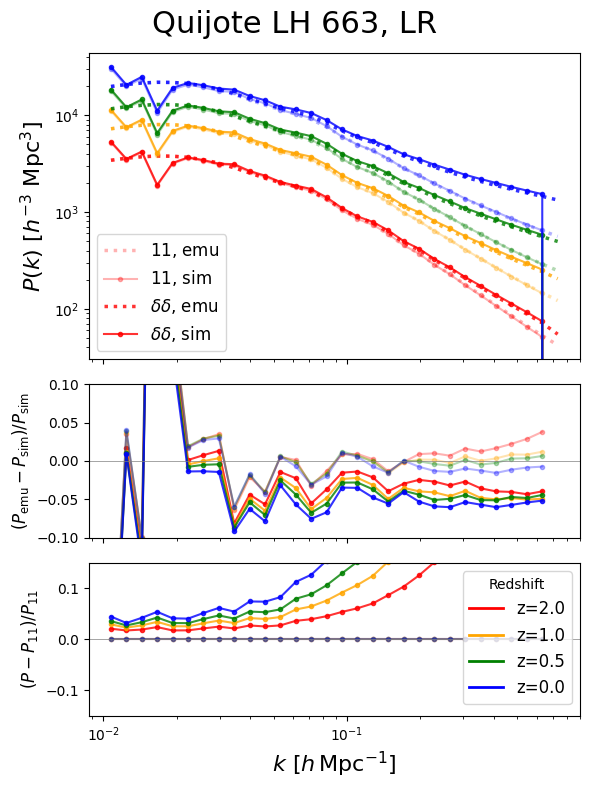

In [71]:
# pnn_emu = pnn_emu_quijote
# power_all_terms = power_all_terms_LR
# pk_obj_delta = pk_obj_delta_LR
sim_name = f'Quijote LH {idx_LH}, LR'

#####

nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
plt.suptitle(sim_name, fontsize=22)

alpha = 0.8

labels_pnn = utils.labels_pnn

color_pdd = 'C'+str(5)

lw = 1.5
lw_emu = 2.5

i_pnn_compare = 0
kk = pk_obj_compare['k']


#is_pnn = [0,1,5]
is_pnn = [0, 5]
alphas_pnn = [0.3, 0.8]

colors_z = ['red', 'orange', 'green', 'blue']
#snapnums = ['000']
for i, snapnum in enumerate(snapnums):
    power_all_terms = power_all_terms_arr[i]
    pk_obj_compare = power_all_terms[i_pnn_compare]

    pnn_emu = pnn_emu_quijote_arr[i]

    label_z = f"z={snapnum2redshift[snapnum]:.1f}"
    for i_pnn in is_pnn:
        pk_obj = power_all_terms[i_pnn]
        # mask = pk_obj['pk'] > 0
        # kk_emu = kk_emu[mask]
        # kk = kk[mask]
        # pk = pk_obj['pk'][mask]
        #color = 'C'+str(i_pnn)
        if i==0:
            label_emu = f'{labels_pnn[i_pnn]}, emu'
            label_sim = f'{labels_pnn[i_pnn]}, sim'
        else:
            label_emu, label_sim = None, None
        color = colors_z[i]
        alpha = alphas_pnn[is_pnn.index(i_pnn)]
        axarr[0].plot(kk_emu, pnn_emu[i_pnn], label=label_emu, 
                     ls=':', alpha=alpha, color=color, lw=lw_emu)
        axarr[0].plot(kk, pk_obj['pk'], 
                    ls='-', lw=lw, alpha=alpha, color=color,
                    marker='o', markersize=3, 
                    label=label_sim)
        axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], 
                    marker='o', markersize=3, 
                    ls='-', lw=lw, alpha=alpha, color=color)
        axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                    ls='-', lw=lw, 
                    marker='o', markersize=3, 
                    alpha=alpha, color=color)

import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))
# is_pnn_lag = [1]
# for i_pnn_lag in is_pnn_lag:
#     i_pnn_corresponding = np.where((prod==[i_pnn_lag,i_pnn_lag]).all(axis=1))[0][0]
# i_pnn_corresponding = 5
# label = utils.labels_pnn[i_pnn_corresponding]+', Lagrangian'
# axarr[0].plot(pk_obj_delta_LR['k'], pk_obj_delta_LR['pk'], 
#                 marker='^', markersize=3, 
#                 label=label, color='grey')
# axarr[2].plot(pk_obj_delta_LR['k'], 
#                 (pk_obj_delta_LR['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
#                 marker='^', markersize=3, 
#                 ls='-', alpha=alpha, color='grey', lw=lw)

ax1.axhline(0.0, color='grey', lw=0.5)
ax2.axhline(0.0, color='grey', lw=0.5)

axarr[-1].set_xlabel(r'$k \,\, [h\,{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
lcomp = utils.labels_pnn[i_pnn_compare].split('$')[1]
#axarr[1].set_ylabel(rf'$(P-P_\text{{{lcomp}}})/P_\text{sim}$', fontsize=12)
#axarr[2].set_ylabel(rf'$(P-P_\text{lcomp})/P_\text{{lcomp}}$', fontsize=12)
axarr[2].set_ylabel(rf'$(P-P_{{{lcomp}}})/P_{{{lcomp}}}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.15, 0.15)

ax.legend(fontsize=12, loc='lower left')

# Create a second legend for redshift
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=colors_z[i], lw=2, label=f"z={snapnum2redshift[snapnums[i]]:.1f}") for i in range(len(snapnums))]
legend_z = plt.legend(handles=legend_elements, loc='upper right', fontsize=12, title='Redshift')
#ax.add_artist(legend_z)
    
ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

## Can b1 absorb the resolution effects between LR and HR?

In [9]:
snapnum = '004' #z=0
fn_bias_fields_lag = f'/scratch/kstoreyf/muchisimocks/data/bias_fields_lag_{idx_LH}_snap{snapnum}.npy'
if os.path.exists(fn_bias_fields_lag):
    bias_fields_lag_LR = np.load(fn_bias_fields_lag)
else:
    bias_fields_lag_LR = create_bias_fields_lag(snapnum=snapnum)
    np.save(fn_bias_fields_lag, bias_fields_lag_LR)

In [12]:
# because we'll be diluting HR so this part is same
bias_fields_lag_HR = bias_fields_lag_LR.copy()

In [13]:
# snapnum = '004' #z=0
# n_grid_HR = 1024
# fn_bias_fields_lag = f'/scratch/kstoreyf/muchisimocks/data/bias_fields_lag_{idx_LH}_snap{snapnum}_HR.npy'
# if os.path.exists(fn_bias_fields_lag):
#     bias_fields_lag_HR = np.load(fn_bias_fields_lag)
# else:
#     bias_fields_lag_HR = create_bias_fields_lag(snapnum=snapnum, n_grid=n_grid_HR)
#     np.save(fn_bias_fields_lag, bias_fields_lag_HR)

In [20]:
bias_fields_eul_LR = compute_bias_fields_eul(bias_fields_lag_LR, snapnum=snapnum)

(134217728,)


2025-03-01 01:27:01,053 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 01:27:01,270 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 01:27:01,834 bacco.statistics :  mesh done in 0.782 s
2025-03-01 01:27:02,221 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 01:27:02,436 bacco.statistics : starting deposit 1
2025-03-01 01:27:02,965 bacco.statistics :  mesh done in 0.744 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 01:27:03,351 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 01:27:03,566 bacco.statistics : starting deposit 1
2025-03-01 01:27:04,100 bacco.statistics :  mesh done in 0.749 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 01:27:04,487 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 01:27:04,702 bacco.statistics : starting deposit 1
2025-03-01 01:27:05,237 bacco.statistics :  mesh done in 0.75 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 01:27:05,624 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 01:27:05,838 bacco.statistics : starting deposit 1
2025-03-01 01:27:06,369 bacco.statistics :  mesh done in 0.745 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


In [22]:
n_grid_HR = 1024
bias_fields_eul_HR = compute_bias_fields_eul(bias_fields_lag_HR, snapnum=snapnum,
                                             n_grid=n_grid_HR, n_fac_dilute=2)

(1073741824,)


2025-03-01 01:28:47,304 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 01:28:48,616 bacco.statistics : starting deposit 1
2025-03-01 01:28:49,177 bacco.statistics :  mesh done in 1.87 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 01:28:52,115 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 01:28:53,133 bacco.statistics : starting deposit 1
2025-03-01 01:28:53,671 bacco.statistics :  mesh done in 1.56 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 01:28:56,112 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 01:28:57,293 bacco.statistics : starting deposit 1
2025-03-01 01:28:57,842 bacco.statistics :  mesh done in 1.73 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 01:29:00,314 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 01:29:01,439 bacco.statistics : starting deposit 1
2025-03-01 01:29:01,976 bacco.statistics :  mesh done in 1.66 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2025-03-01 01:29:04,478 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-03-01 01:29:05,430 bacco.statistics : starting deposit 1
2025-03-01 01:29:05,978 bacco.statistics :  mesh done in 1.5 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


In [25]:
power_all_terms_LR = compute_pk_terms(bias_fields_eul_LR, snapnum=snapnum)

2025-03-01 01:30:09,368 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.796955 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.381356 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000201 secs
bacco.power : Deallocating arrays


2025-03-01 01:30:12,764 bacco.statistics :  ...done in 3.4 s
2025-03-01 01:30:12,766 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 8.04864e-11 (grid1) 8.04864e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.780507 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.375639 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000147 secs
bacco.power : Deallocating arrays


2025-03-01 01:30:15,525 bacco.statistics :  ...done in 2.76 s


In [29]:
power_all_terms_HR = compute_pk_terms(bias_fields_eul_HR, snapnum=snapnum,
                                      n_grid=n_grid)

2025-03-01 01:30:48,417 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.758568 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.377633 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000211 secs
bacco.power : Deallocating arrays


2025-03-01 01:30:52,053 bacco.statistics :  ...done in 3.64 s
2025-03-01 01:30:52,054 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


[1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.96438e-11 (grid1) 9.96438e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.781998 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.606158 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000228 secs
bacco.power : Deallocating arrays


2025-03-01 01:30:55,694 bacco.statistics :  ...done in 3.64 s


In [31]:
p_dd_LR = power_all_terms_LR[5]['pk']
p_dd_HR = power_all_terms_HR[5]['pk']

In [32]:
### emulator predictions
kk = power_all_terms_LR[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]

expfactor = snapnum2expfactor[snapnum]
cosmo_quijote_z = utils.get_cosmo(param_dict, a_scale=expfactor)
cosmo_params_emu_quijote_z = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_quijote_z)

_, pnn_emu_quijote = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_quijote_z)
p_dd_emu = pnn_emu_quijote[5]

In [33]:
from scipy.optimize import curve_fit

# Define the fitting function: P_low_res / b1^2 should match P_high_res
def bias_model(b1, P_low_res):
    return p_dd_LR / b1**2

# Fit b1 by minimizing the difference between the rescaled low-res spectrum and the high-res spectrum
popt, pcov = curve_fit(lambda b1, _: bias_model(b1, p_dd_LR), 
                       xdata=np.zeros_like(p_dd_HR), ydata=p_dd_HR, p0=[1.0])
b1_best = popt[0]

# Rescale the low-resolution power spectrum
p_dd_LR_scaled = p_dd_LR / b1_best**2

print(f"Best-fit b1: {b1_best:.3f}")


Best-fit b1: 1.000


/tmp/ipykernel_2553626/761398169.py:5: RuntimeWarning: divide by zero encountered in divide
  return p_dd_LR / b1**2
/tmp/ipykernel_2553626/761398169.py:5: RuntimeWarning: invalid value encountered in divide
  return p_dd_LR / b1**2
/tmp/ipykernel_2553626/761398169.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(lambda b1, _: bias_model(b1, p_dd_LR),


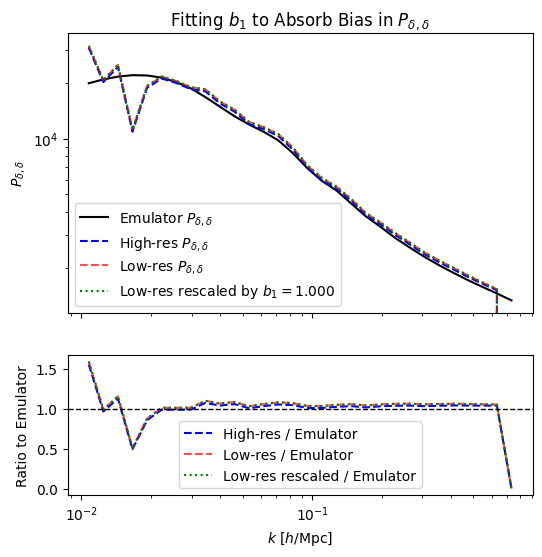

In [34]:
# Define colors and linestyles for easy customization
colors = ['black', 'blue', 'red', 'green']
linestyles = ['solid', 'dashed', 'dotted']

# Create a two-panel plot
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Upper panel: Power spectra
axs[0].loglog(kk, p_dd_emu, label="Emulator $P_{\delta, \delta}$", color=colors[0], linestyle=linestyles[0])
axs[0].loglog(kk, p_dd_HR, label="High-res $P_{\delta, \delta}$", color=colors[1], linestyle=linestyles[1])
axs[0].loglog(kk, p_dd_LR, label="Low-res $P_{\delta, \delta}$", color=colors[2], linestyle=linestyles[1], alpha=0.7)
axs[0].loglog(kk, p_dd_LR_scaled, label=f"Low-res rescaled by $b_1={b1_best:.3f}$", color=colors[3], linestyle=linestyles[2])

axs[0].set_ylabel(r"$P_{\delta, \delta}$")
axs[0].legend()
axs[0].set_title(r"Fitting $b_1$ to Absorb Bias in $P_{\delta, \delta}$")

# Lower panel: Ratio to emulator
axs[1].semilogx(kk, p_dd_HR / p_dd_emu, label="High-res / Emulator", color=colors[1], linestyle=linestyles[1])
axs[1].semilogx(kk, p_dd_LR / p_dd_emu, label="Low-res / Emulator", color=colors[2], linestyle=linestyles[1], alpha=0.7)
axs[1].semilogx(kk, p_dd_LR_scaled / p_dd_emu, label=f"Low-res rescaled / Emulator", color=colors[3], linestyle=linestyles[2])

axs[1].set_xlabel(r"$k$ [$h$/Mpc]")
axs[1].set_ylabel("Ratio to Emulator")
axs[1].axhline(1, color='black', linestyle="dashed", linewidth=1)
axs[1].legend()
